# Plotting the metric curves

This file contains functions for plotting the metric curves in the paper.

In [1]:
%matplotlib inline
import os
import errno
import warnings
import numpy as np
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
# deal with the bold roman font bug, see https://github.com/matplotlib/matplotlib/issues/5574
matplotlib.font_manager._rebuild()
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.size'] = 16.0
plt.rcParams['savefig.dpi'] = 150

In [3]:
def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

def color_variant(hex_color, brightness_offset=1):
    """ takes a color like #87c95f and produces a lighter or darker variant """
    if len(hex_color) != 7:
        raise Exception("Passed %s into color_variant(), needs to be in #87c95f format." % hex_color)
    rgb_hex = [hex_color[x:x+2] for x in [1, 3, 5]]
    new_rgb_int = [int(hex_value, 16) + brightness_offset for hex_value in rgb_hex]
    new_rgb_int = [min([255, max([0, i])]) for i in new_rgb_int] # make sure new values are between 0 and 255
    # hex() produces "0x88", we want just "88"
    return "#" + "".join(['{:0>2}'.format(hex(i)[2:]) for i in new_rgb_int])

In [4]:
data_dir = './data'
result_dir = './figs/'
extension = 'png' # 'pdf', 'ps', 'eps', 'svg'
make_sure_path_exists(result_dir)
make_sure_path_exists(os.path.join(result_dir, 'two-stage'))
make_sure_path_exists(os.path.join(result_dir, 'end2end'))
make_sure_path_exists(os.path.join(result_dir, 'ablated'))

In [5]:
train_path = "./eval_statistics/lastfm_alternative_8b_phrase/score_matrices.npy"
train = np.load(train_path)

In [6]:
track_names = ('Drums', 'Piano', 'Guitar', 'Bass', 'Ensemble', 'Reed', 'Synth Lead', 'Synth Pad')
metric_names = (
    'empty bar rate',
    '# of pitch used',
    'qualified note rate',
    'polyphonicity',
    'note in scale',
    'drum in pattern rate',
    '# of chroma used'
)
metric_file_names = (
    'empty_bar_rate',
    'num_pitch_used',
    'qualified_note_rate',
    'polyphonicity',
    'note_in_scale',
    'drum_in_pattern',
    'num_chroma_used'
)

## Load merged metric values

In [7]:
def load_metrics(filepath, start_step=0):
    """Load a merged metric file and return a dictionary containing metric arrays."""
    results = {}
    with np.load(filepath) as loaded:
        results['steps'] = loaded['steps'] + start_step
        results['score_matrix_means'] = loaded['score_matrix_means']
        results['score_pair_matrix_means'] = loaded['score_pair_matrix_means']
    return results

def update_metrics(filepath, metric_dict, start_step=0):
    """Update a metric array dictionary with a merged metric file."""
    with np.load(filepath) as loaded:
        mask = (metric_dict['steps'] < loaded['steps'].min() + start_step)
        metric_dict['steps'] = np.concatenate((metric_dict['steps'][mask], loaded['steps'] + start_step))
        metric_dict['score_matrix_means'] = np.concatenate((metric_dict['score_matrix_means'][mask], loaded['score_matrix_means']))
        metric_dict['score_pair_matrix_means'] = np.concatenate((metric_dict['score_pair_matrix_means'][mask], loaded['score_pair_matrix_means']))

In [8]:
proposed = load_metrics(os.path.join(data_dir, "pretrain_alternative_proposed.npz"))
ablated = load_metrics(os.path.join(data_dir, "pretrain_alternative_ablated.npz"))
baseline = load_metrics(os.path.join(data_dir, "pretrain_alternative_baseline.npz"))

In [9]:
train_start_step = 55470 # steps when second-stage training start

r = load_metrics(os.path.join(data_dir, "train_alternative_proposed_round.npz"), train_start_step)
b = load_metrics(os.path.join(data_dir, "train_alternative_proposed_bernoulli.npz"), train_start_step)
jr = load_metrics(os.path.join(data_dir, "train_alternative_proposed_round_joint.npz"), train_start_step)
jb = load_metrics(os.path.join(data_dir, "train_alternative_proposed_bernoulli_joint.npz"), train_start_step)

update_metrics(os.path.join(data_dir, "train_alternative_proposed_round_keep_train.npz"), r, train_start_step)
update_metrics(os.path.join(data_dir, "train_alternative_proposed_bernoulli_keep_train.npz"), b, train_start_step)

mask = (b['steps'] < 99200)
b['steps'] = b['steps'][mask]
b['score_matrix_means'] = b['score_matrix_means'][mask]
b['score_pair_matrix_means'] = b['score_pair_matrix_means'][mask]

In [10]:
end2end_r = load_metrics(os.path.join(data_dir, "end2end_alternative_proposed_smaller_round.npz"))
end2end_b =  load_metrics(os.path.join(data_dir, "end2end_alternative_proposed_smaller_bernoulli.npz"))
    
update_metrics(os.path.join(data_dir, "end2end_alternative_proposed_smaller_round_keep_train.npz"), end2end_r)
update_metrics(os.path.join(data_dir, "end2end_alternative_proposed_smaller_bernoulli_keep_train.npz"), end2end_b)

## Comparison of Training Strategies
We compare the proposed training strategy with two alternative ones.
- **proposed**: pretrain G and D in the first stage, and then train R and D (while G is fixed) in the second stage.
- **joint**: pretrain G and D in the first stage, and then train G and R (like viewing R as part of G) jointly with D in the second stage.
- **end-to-end**: train G, R and D jointly in one stage.

### Comparison of Two-stage Training Strategies

In [11]:
k = 5
h = (k - 1)//2
smooth = 'med' # 'avg', med', None

locs = [3, 2, 3, 2, 4, 3, 2]
ylims = [(0, 1), (0, 20), (0, 1), (0, 1), (0, 1), (0, 1), (0, 10)]

def plot(x, m, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        if smooth == None or smooth == 'none':
            plt.plot(x['steps'], np.nanmean(x['score_matrix_means'][:, m, :], axis=1), '-', zorder=1, **kwargs)
        elif smooth == 'avg':
            plt.plot(x['steps'][h:-h], movingaverage(np.nanmean(x['score_matrix_means'][:, m, :], axis=1), k), '-', zorder=1, **kwargs)
        elif smooth == 'med':
            plt.plot(x['steps'][h:-h], scipy.signal.medfilt(np.nanmean(x['score_matrix_means'][:, m, :], axis=1), k)[h:-h], '-', zorder=1, **kwargs)
        if smooth != 'none':
            
            plt.plot(x['steps'], np.nanmean(x['score_matrix_means'][:, m, :], axis=1), '-', linewidth=.3, color='0.7', zorder=0)

def plot_metrics(m, save=False, close=False):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])
    
    plot(proposed, m, label='pretrain', linewidth=.8)
    plot(r, m, label='proposed (+DBNs)', linewidth=.8)
    plot(b, m, label='proposed (+SBNs)', linewidth=.8)
    plot(jr, m, label='joint (+DBNs)', linewidth=.8)
    plot(jb, m, label='joint (+SBNs)', linewidth=.8)

    plt.axhline(y=np.nanmean(train[()]['score_matrix_mean'][m, :]), color='r', linestyle='--', linewidth=1.0, zorder=0)
    plt.xlabel('step', fontweight='bold')
    plt.ylabel(metric_names[m], fontweight='bold')
    plt.gca().set_xlim(left=0)
    plt.ylim(ylims[m][0], ylims[m][1])
    plt.legend(loc=locs[m], prop={'size': 12, 'weight': 'bold'})
    plt.setp(plt.gca().spines.values(), linewidth=1.5)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.tick_params(direction='in')
    if save:
        plt.savefig(os.path.join(result_dir, 'two-stage', 'two-stage_{}.'.format(metric_file_names[m]) + extension), bbox_inches='tight')
    if close:
        plt.close()

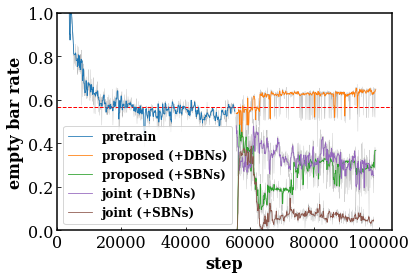

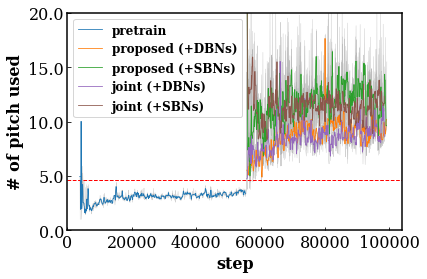

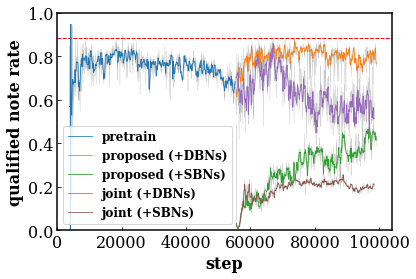

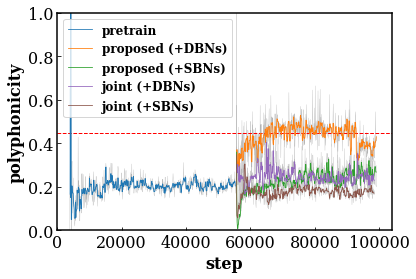

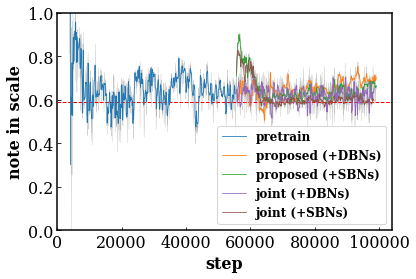

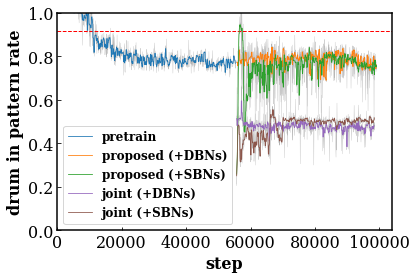

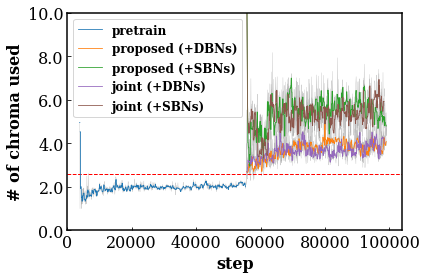

In [12]:
for m in range(7):
    plt.figure()
    plot_metrics(m, True)

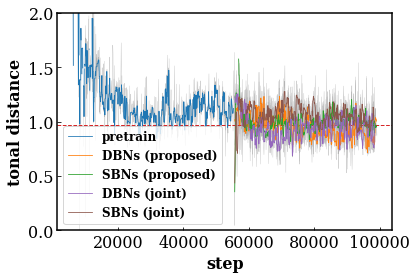

In [13]:
k = 5
h = (k - 1)//2
smooth = 'med' # 'avg', 'med', None

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])

def plot(x, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        if smooth == None or smooth == 'none':
            plt.plot(x['steps'], x['score_pair_matrix_means'][:, 0], '-', zorder=1, **kwargs)
        elif smooth == 'avg':
            plt.plot(x['steps'][h:-h], movingaverage(x['score_pair_matrix_means'][:, 0], k), '-', zorder=1, **kwargs)
        elif smooth == 'med':
            plt.plot(x['steps'][h:-h], scipy.signal.medfilt(x['score_pair_matrix_means'][:, 0], k)[h:-h], '-', zorder=1, **kwargs)
        if smooth != 'none':
            plt.plot(x['steps'], x['score_pair_matrix_means'][:, 0], '-', linewidth=.3, color='0.7', zorder=0)

plot(proposed, label='pretrain', linewidth=.8)
plot(r, label='DBNs (proposed)', linewidth=.8)
plot(b, label='SBNs (proposed)', linewidth=.8)
plot(jr, label='DBNs (joint)', linewidth=.8)
plot(jb, label='SBNs (joint)', linewidth=.8)

plt.axhline(y=train[()]['score_pair_matrix_mean'][0], color='tab:red', linestyle='--', linewidth=1.0, zorder=0)
plt.xlabel('step', fontweight='bold')
plt.ylabel('tonal distance', fontweight='bold')
plt.ylim(0, 2)
plt.legend(loc=3, prop={'size': 12, 'weight': 'bold'})
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tick_params(direction='in')

plt.savefig(os.path.join(result_dir, 'two-stage', 'two-stage_tonal_distance.' + extension), bbox_inches='tight')

### Comparison of End-to-end Training Strategies

In [14]:
k = 3
h = (k - 1)//2
smooth = 'med' # 'avg', med', None

locs_end2end = [1, 1, 1, 1, 4, 4, 1]
ylims_end2end = [(0, 1), (0, 20), (0, 1), (0, 1), (0, 1), (0, 1), (0, 8)]

def plot(x, m, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        if smooth == None or smooth == 'none':
            plt.plot(x['steps'], np.nanmean(x['score_matrix_means'][:, m, :], axis=1), '-', zorder=1, **kwargs)
        elif smooth == 'avg':
            plt.plot(x['steps'][h:-h], movingaverage(np.nanmean(x['score_matrix_means'][:, m, :], axis=1), k), '-', zorder=1, **kwargs)
        elif smooth == 'med':
            plt.plot(x['steps'][h:-h], scipy.signal.medfilt(np.nanmean(x['score_matrix_means'][:, m, :], axis=1), k)[h:-h], '-', zorder=1, **kwargs)
        if smooth != 'none':
            plt.plot(x['steps'], np.nanmean(x['score_matrix_means'][:, m, :], axis=1), '-', linewidth=.3, color='0.7', zorder=0)

def plot_metrics(m, save=False, close=False):
    plot(end2end_r, m, label='end-to-end (+DBNs)', linewidth=.8)
    plot(end2end_b, m, label='end-to-end (+SBNs)', linewidth=.8)

    plt.axhline(y=np.nanmean(train[()]['score_matrix_mean'][m, :]), color='tab:red', linestyle='--', linewidth=1.0, zorder=0)
    plt.xlabel('step', fontweight='bold')
    plt.ylabel(metric_names[m], fontweight='bold')
    plt.gca().set_xlim(left=0)
    plt.ylim(ylims_end2end[m][0], ylims_end2end[m][1])
    plt.legend(loc=locs_end2end[m], prop={'size': 12, 'weight': 'bold'})
    plt.setp(plt.gca().spines.values(), linewidth=1.5)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.tick_params(direction='in')

    if save:
        plt.savefig(os.path.join(result_dir, 'end2end', 'end2end_{}.'.format(metric_file_names[m]) + extension), bbox_inches='tight')
    if close:
        plt.close()

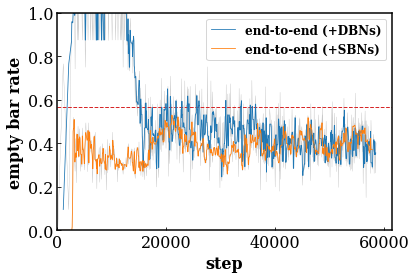

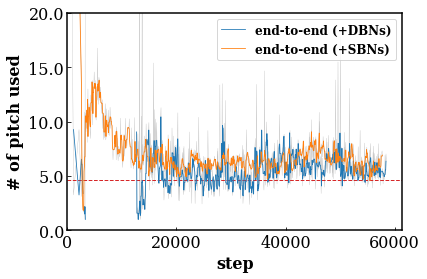

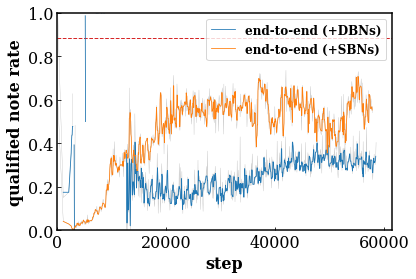

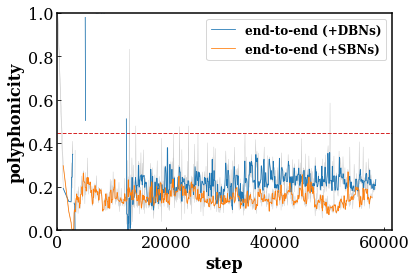

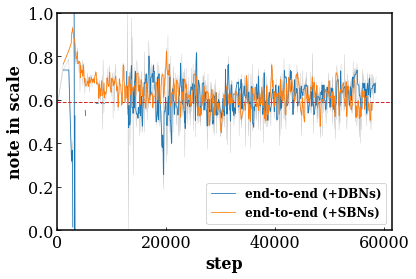

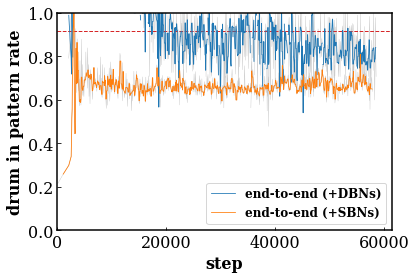

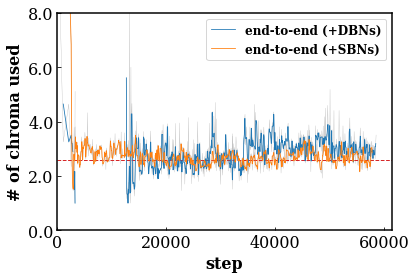

In [15]:
for m in range(7):
    plt.figure()
    plot_metrics(m, True)

## Effects of the Shared/private and Multi-stream Design of the Discriminator

We compare the proposed model with its ablated version and a baseline model.

- **ablated**: remove the onset/offset and chroma streams.
- **baseline**: use only a shared discriminator without the shared/private design.

In [16]:
k = 5
h = (k - 1)//2
m = 2
smooth = 'med' # 'avg', med', None

locs_ablated = [1, 1, 1, 1, 4, 4, 1]
ylims_ablated = [(0, 1), (0, 11), (0, 1), (0, 1), (0, 1), (.5, 1), (0, 8)]

def plot(x, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        if smooth == None or smooth == 'none':
            plt.plot(x['steps'], np.nanmean(x['score_matrix_means'][:, m, :], axis=1), '-', zorder=1, **kwargs)
        elif smooth == 'avg':
            plt.plot(x['steps'][h:-h], movingaverage(np.nanmean(x['score_matrix_means'][:, m, :], axis=1), k), '-', zorder=1, **kwargs)
        elif smooth == 'med':
            plt.plot(x['steps'][h:-h], scipy.signal.medfilt(np.nanmean(x['score_matrix_means'][:, m, :], axis=1), k)[h:-h], '-', zorder=1, **kwargs)
        if smooth != 'none':
            plt.plot(x['steps'], np.nanmean(x['score_matrix_means'][:, m, :], axis=1), '-', linewidth=.3, color='0.7', zorder=0)

def plot_metrics(m, save=False, close=False):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])
    
    plot(proposed, label='proposed', linewidth=.8)
    plot(ablated, label='ablated', linewidth=.8)
    plot(baseline, label='baseline', linewidth=.8)

    plt.axhline(y=np.nanmean(train[()]['score_matrix_mean'][m, :]), color='tab:red', linestyle='--', linewidth=1.0, zorder=0)
    plt.xlabel('step', fontweight='bold')
    plt.ylabel(metric_names[m], fontweight='bold')
    plt.ylim(ylims_ablated[m][0], ylims_ablated[m][1])
    plt.legend(loc=locs_ablated[m], prop={'size': 12, 'weight': 'bold'})
    plt.setp(plt.gca().spines.values(), linewidth=1.5)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.tick_params(direction='in')
    
    if save:
        plt.savefig(os.path.join(result_dir, 'ablated', 'ablated_{}.'.format(metric_file_names[m]) + extension), bbox_inches='tight')
    if close:
        plt.close()

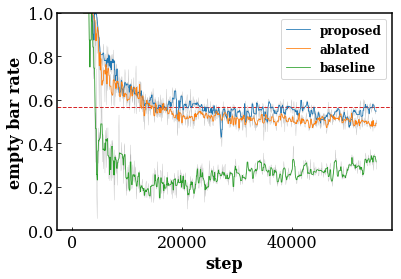

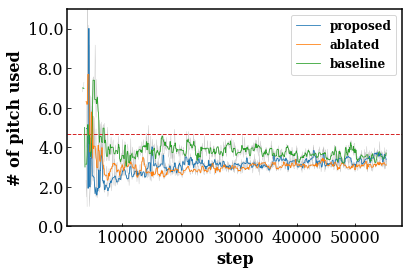

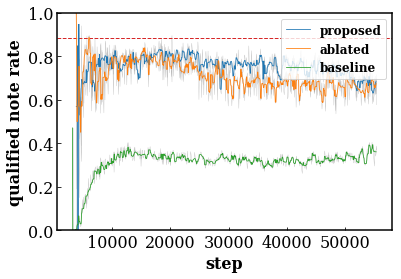

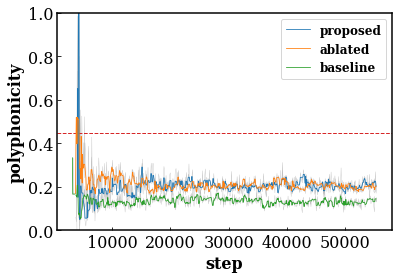

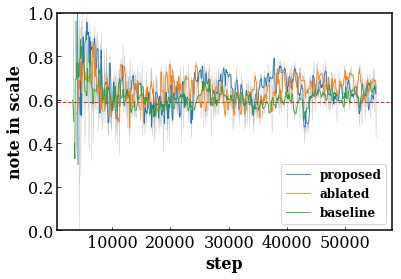

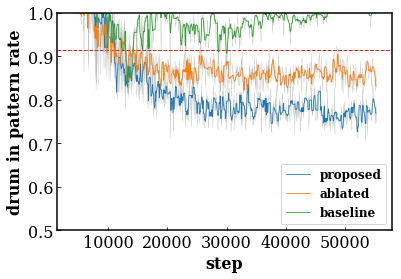

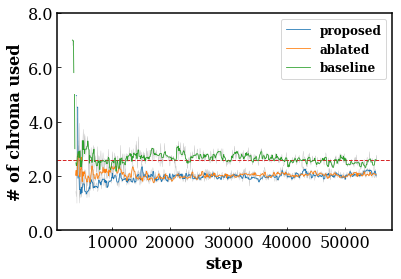

In [17]:
for m in range(7):
    plt.figure()
    plot_metrics(m, True)

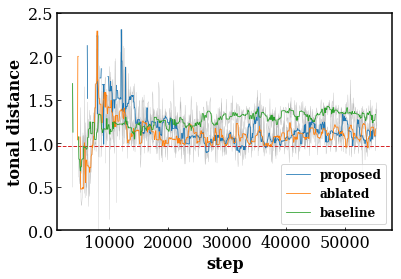

In [18]:
k = 9
h = (k-1)//2
m = 0
smooth = 'med' # 'med', None

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])

def plot(x, **kwargs):
    if smooth == None or smooth == 'none':
        plt.plot(x['steps'], x['score_pair_matrix_means'][:, 0], '-', zorder=1, **kwargs)
    elif smooth == 'avg':
        plt.plot(x['steps'][h:-h], movingaverage(x['score_pair_matrix_means'][:, 0], k), '-', zorder=1, **kwargs)
    elif smooth == 'med':
        plt.plot(x['steps'][h:-h], scipy.signal.medfilt(x['score_pair_matrix_means'][:, 0], k)[h:-h], '-', zorder=1, **kwargs)
    if smooth != 'none':
        plt.plot(x['steps'], x['score_pair_matrix_means'][:, 0], '-', linewidth=.3, color='0.7', zorder=0)
        
plot(proposed, label='proposed', linewidth=.8)
plot(ablated, label='ablated', linewidth=.8)
plot(baseline, label='baseline', linewidth=.8)
        
plt.axhline(y=train[()]['score_pair_matrix_mean'][0], color='tab:red', linestyle='--', linewidth=1.0, zorder=0)
plt.xlabel('step', fontweight='bold')
plt.ylabel('tonal distance', fontweight='bold')
plt.ylim(0.0, 2.5)
plt.legend(loc=4, prop={'size': 12, 'weight': 'bold'})
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tick_params(direction='in')

plt.savefig(os.path.join(result_dir, 'ablated', 'ablated_tonal_distance.' + extension), bbox_inches='tight')